In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from time import time

import tensorflow as tf
from tensorflow import keras

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

## Examine the Dataset
Each instance is a 28x28 image of a hand written digit. In total there are 60000 training images and 10000 testing images.

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
# Normalize the data
x_train = x_train/255
x_test = x_test/255

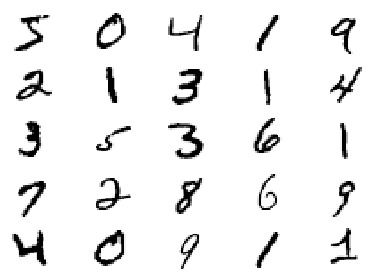

In [106]:
fig, ax_array = plt.subplots(5, 5)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(x_train[i], cmap='Greys')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

## Dimensionality reduction with Linear PCA
We can reduce the dimension from 784 to 2 and see some basic cluster when the digits are plotted in this new vector space. In fact, this reduction captures ~93% of the variance in the images.

In [107]:
pca = PCA(n_components=2)

In [108]:
pca_train = pca.fit_transform(x_train.reshape(-1, 28*28))

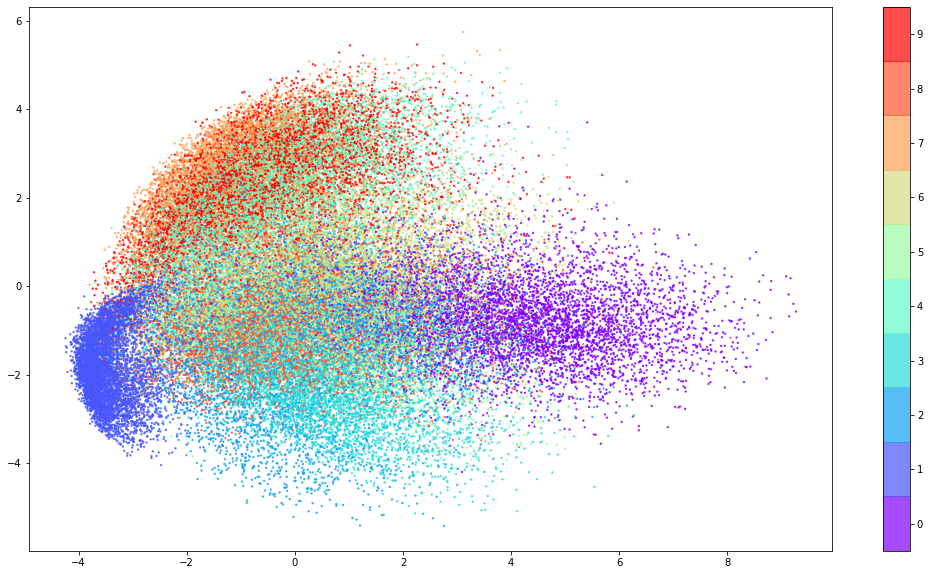

In [109]:
plt.figure(figsize=[18,10])
plt.scatter(pca_train[:,0], pca_train[:,1], c = y_train, cmap='rainbow', s=2, alpha = .7)
cbar = plt.colorbar(boundaries = np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))

In [112]:
1 - pca.explained_variance_ratio_[-1]

0.929040759480442

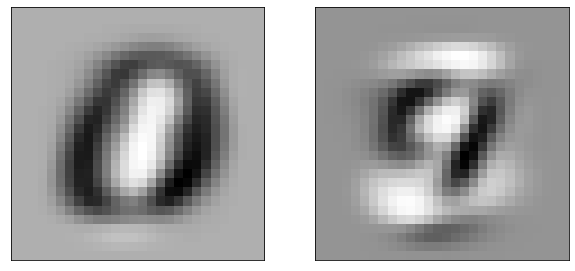

In [113]:
# Plot the two "eigen-digits"
fig, ax_array = plt.subplots(1, 2, figsize=[10, 10])
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(pca.components_[i].reshape(28,28), cmap='Greys')
plt.setp(axes, xticks=[], yticks=[]);

In this new reduced vector space the digits looked blurred out. It turns out that the 7% of the variance lost also captures much of the subtlety of the handwritten digits.

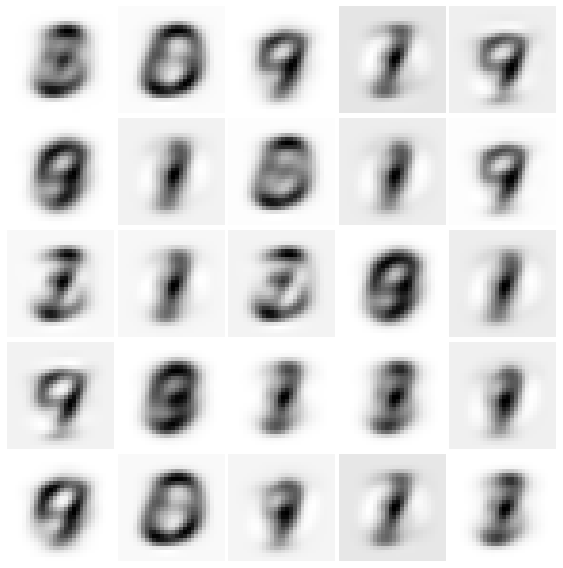

In [114]:
x_train_reduced = pca.inverse_transform(pca_train)

fig, ax_array = plt.subplots(5, 5, figsize=[8, 8])
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(x_train_reduced.reshape(-1,28,28)[i], cmap='Greys')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

Using 25 compponets captures much more of the variance.

In [4]:
big_pca = PCA(n_components=25)

In [5]:
big_pca_train = big_pca.fit_transform(x_train.reshape(-1, 28*28))

In [117]:
# Now we are capturing ~99 percent of the variance.
1 - big_pca.explained_variance_ratio_[-1]

0.9911734980506182

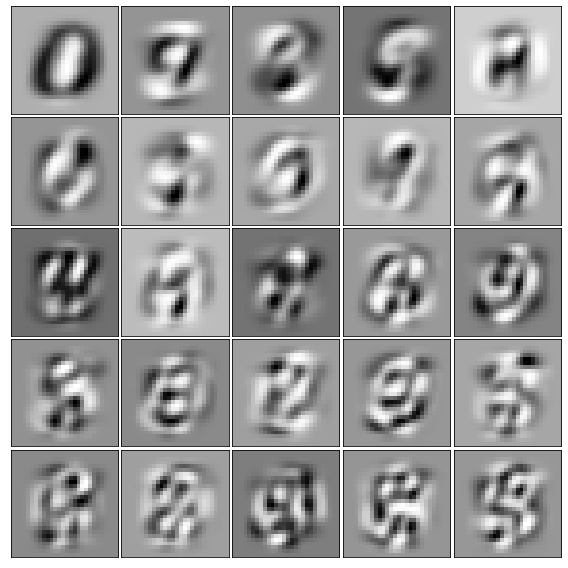

In [118]:
# Here are the first 25 "eigen-digits"
fig, ax_array = plt.subplots(5, 5, figsize=[8, 8])
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(big_pca.components_[i].reshape(28,28), cmap='Greys')
plt.setp(axes, xticks=[], yticks=[]);
plt.tight_layout(h_pad=0, w_pad=0.01)

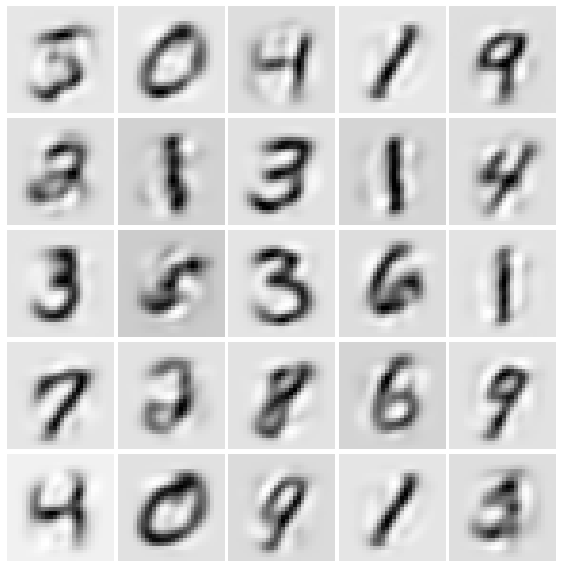

In [119]:
x_train_reduced_big = big_pca.inverse_transform(big_pca_train)

fig, ax_array = plt.subplots(5, 5, figsize=[8, 8])
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(x_train_reduced_big.reshape(-1,28,28)[i], cmap='Greys')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

## Lets look at a nonlinear visualization: t-SNE
This unsupervised learning algorithm is able to cluster the digits

In [8]:
x_train_tsne = TSNE(n_components=2).fit_transform(x_train[:5000].reshape(-1, 28*28))

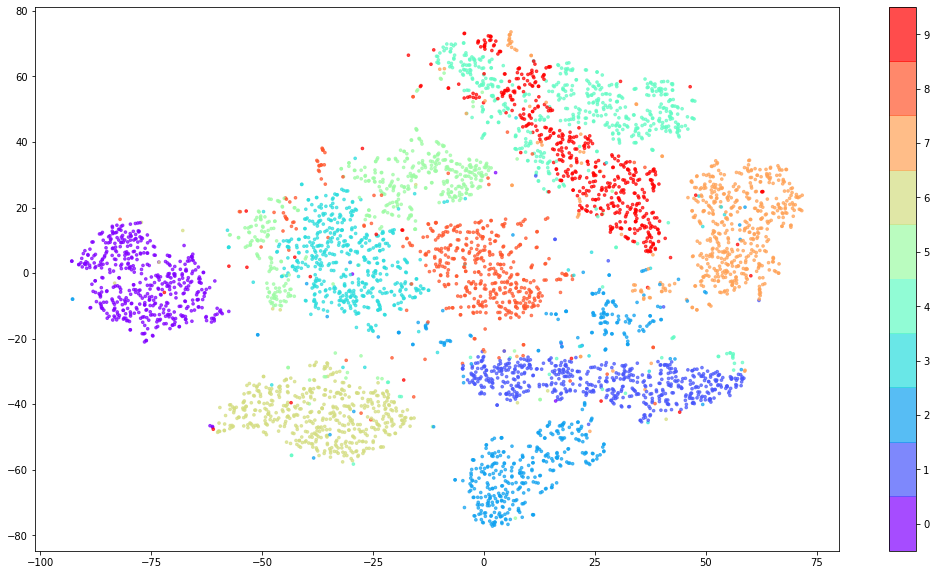

In [11]:
plt.figure(figsize=[18,10])
plt.scatter(x_train_tsne[:,0], x_train_tsne[:,1], c = y_train[:5000], cmap='rainbow', s=7, alpha = .7)
cbar = plt.colorbar(boundaries = np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))

## Logistic Regression and SVM to classify digits
Logistic regression is not nearly as good as a kernal Support Vector machine in classifying the digits. However, the support vector machines are very computationally expensive.

In [120]:
t0 = time()
lr = LogisticRegression()
lr.fit(x_train.reshape(-1, 28*28), y_train)
print("Logistic Regression training done in %0.3fs" % (time() - t0))

Logistic Regression training done in 7.656s


In [121]:
t0 = time()
print("Logistic Regression Accuracy: %0.3f percent" %lr.score(x_test.reshape(-1, 28*28), y_test))
print("Logistic Regression testing done in %0.3fs" % (time() - t0))

Logistic Regression Accuracy: 0.926 percent
Logistic Regression testing done in 0.013s


In [122]:
t0 = time()
clf = SVC(gamma='scale', C=1, class_weight='balanced')
clf.fit(x_train.reshape(-1, 28*28), y_train)
print("SVM training done in %0.3fs" % (time() - t0))

SVM training done in 469.673s


In [123]:
t0 = time()
print(clf.score(x_test.reshape(-1, 28*28), y_test))
print("SVM testing done in %0.3fs" % (time() - t0))

0.9796
SVM testing done in 138.389s


## Dimension Reduction with PCA speeds up SVM 
No accuracy is sacrificed. 

In [8]:
t0 = time()
pca_clf = SVC(gamma='scale', C=1, class_weight='balanced')
pca_clf.fit(big_pca_train, y_train)
print("SVM training done in %0.3fs" % (time() - t0))

SVM training done in 16.193s


In [9]:
t0 = time()
x_test_pca = big_pca.transform(x_test.reshape(-1, 28*28))
print(pca_clf.score(x_test_pca, y_test))
print("SVM testing done in %0.3fs" % (time() - t0))

0.978
SVM testing done in 4.136s
